[Last chapter](../03_oner/oner.ipynb) we implemented the OneR [@Holte1993] algorithm. In this chapter we'll improve the model without improving the model. Sounds strange, but bear with me. This chapter is all about changing the input to the model.

Right now we just pass the length as input. It's a simple way to represent reviews as a number (see @sec-feature-extraction-intro). In fact it's too simple which is why our model hasn't improved from 50% accuracy. Now we will focus on creating a richer representation of the reviews for our model, one that the model can actually learn from.

## Bag of characters

Text data is rich in information, with the ordering of characters, words, and sentences all contributing to structure and meaning. There are several ways to capture that information and represent it as a matrix of numbers. We will start with characters as these are the foundational building blocks of words.

We can count the number of each character in a review and represent that review as the count of each character. This representation is called a bag of characters and it can be extended to words, sentences, or whatever you want really. And of course `sklearn` has a way to do this with `CountVectorizer`.[`CountVectotrizer` returns a [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html) which are memory efficient for matrices that contain mostly 0s.]{.aside} This class creates a `dict` mapping characters (or words) to array indices when fitting to training data. Then, when other data is transformed to a bag of characters, it counts up each character and puts them in an array at the specified indices in the map.

In [1]:
from nlpbook import get_train_test_data
from sklearn.feature_extraction.text import CountVectorizer

train_df, test_df = get_train_test_data()

# Create the bag of characters feature extraction transformer.
# The `CountVectorizer` class bags input text. We set
# `analyzer="char"` so that `CountVectorizer` counts characters
# instead of words and `lowercase=False` to prevent upper case
# letters from being converted to lowercase.
vectorizer = CountVectorizer(analyzer="char", lowercase=False)

# Fit the bag of characters transformer on our reviews.
# Notice we do not pass a matrix into the fit method, but an array.
# Feature extraction should be performed on a per column basis so
# we need to pass in the column we want feature extraction performed
# on.
vectorizer.fit(train_df["review"])

# Transform the first row to a bag of characters.
# Convert the sparse matrix to a numpy array to see the counts.
vectorizer.transform(train_df["review"].head(1)).toarray()

array([[  0,   0,   0, 275,   0,   6,   0,   0,   0,   1,   5,   1,   1,
          0,   0,  25,   4,  16,   8,   0,   2,   0,   0,   0,   0,   0,
          0,   1,   2,   0,   0,   8,   0,   8,   0,   0,   2,   5,   0,
          1,   0,   0,   3,   2,   3,   0,   0,   3,   5,   2,   1,   1,
          0,   2,   1,   5,   1,   0,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  99,  24,  23,  50, 166,  31,  21,  64,  84,   1,
          5,  61,  27,  89,  92,  30,   1,  94,  90, 122,  29,  13,  17,
          0,  35,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

This is our bag of characters. Each element in this array is a count of some character. We can check what character each array element is counting with the `vocabulary_` dict.

In [2]:
list(vectorizer.vocabulary_.items())[:5]

[('"', 5), ('N', 49), ('a', 68), ('t', 87), ('i', 76)]

So index 5 of the above array is the counts for the character `"`, index 49 is the counts for `N`, and so on.

## Transformers

What we've worked with so far in scikit-learn are estimators. These are machine learning models. scikit-learn has another common type of class called transformers, which transform data as the name implies. These classes are commonly used for preprocessing tasks. They do not have a predict method, but instead have a `transform` method. We "train" them with `fit` just like we would a model, but these objects are used for consistent preprocessing and not prediction. `CountVectorizer` is a transformer, hence the `transform` method.

## OneR revisited

Now we can just pass this as input to our OneR model right? Not quite, our model isn't capable of handling this input yet. Here's the implementation from last chapter.

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.dummy import DummyClassifier
from sklearn.utils.multiclass import unique_labels


class OneR(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        """Train on the categories in the first column of `X`."""
        # Store the classes.
        # sklearn provides a handy function `unique_labels` for this
        # purpose. You could also use `np.unique`.
        self.classes_ = unique_labels(y)

        predictors = {}
        # Get the unique categories from `X`.
        categories = np.unique(X)
        for value in categories:
            # Create a boolean array where `True` indices indicate the
            # rows that have this value.
            is_value = X == value

            # Grab all data points and labels with this value.
            _X = X[is_value]
            _y = y[is_value]

            # Train a baseline classifier on the value.
            predictors[value] = DummyClassifier().fit(_X, _y)

        self.predictors_ = predictors

        # Create a fallback predictor for unknown categories.
        self.unknown_predictor_ = DummyClassifier().fit(X, y)
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        # Create an empty array that will hold the predictions.
        rv = np.zeros(len(X), dtype=int)

        # Get the unique categories from `X`.
        categories = np.unique(X)
        for value in categories:
            # Create a boolean array where `True` indices indicate the
            # rows that have this value.
            is_value = X == value

            # Grab all data points in this value.
            _X = X[is_value]

            # Predict the label for all datapoints in `_X`.
            try:
                predictions = self.predictors_[value].predict(_X)
            except KeyError:
                # Fallback to the predictor for unknown categories.
                predictions = self.unknown_predictor_.predict(_X)

            # Assign the prediction for this value to
            # the corresponding indices in `rv`.
            rv[is_value] = predictions
        return rv

Notice `X` is an array, but we are passing in a matrix from here on out. Each row will have multiple features to accomodate for each character which raises a problem. OneR works on one feature and now we have many.

Previously, I said the algorithm works by predicting the most frequent label for each category. This is only half the story of the OneR algorithm. The other half of the story is it does this for _every feature_, then makes predictions based on the _best feature_. When we first implemented this model we only had one feature so it didn't matter, but now we have many, so we need to tweak the implementation to find the best feature when given any number of features.

In [4]:
import scipy.sparse

# Rename the `OneR` class to `Rule`.
Rule = OneR


# Create a new `OneR` class which finds the best `Rule` in the
# dataset.
class OneR(ClassifierMixin, BaseEstimator):
    def fit(self, X, y):
        """Find the best rule in the dataset."""
        self.classes_ = unique_labels(y)

        col_idx = score = rule = None

        # Iterate over each feature.
        # `numpy` and `scipy` iterate over rows. Rows are data points.
        # We want the columns (features). An easy trick to iterate
        # over columns is to transpose the matrix which flips it along
        # its diagonal.
        for i, column in enumerate(X.T):
            # Convert sparse matrix to `numpy` array.
            # `Rule` works on numpy arrays, so we should use consistent
            # array types.
            if scipy.sparse.issparse(column):
                column = column.toarray()

            # `column` has matrix shape (1, N) but we need array shape (N,).
            # Use `np.squeeze` to flatten to 1D array.
            column = column.squeeze()

            # Create a rule for the ith column.
            rule_i = Rule().fit(column, y)
            # Score the ith columns accuracy.
            score_i = rule_i.score(column, y)

            # Keep the rule for the ith column if it has the highest
            # accuracy so far.
            if score is None or score_i > score:
                rule = rule_i
                score = score_i
                col_idx = i

        self.rule_ = rule
        self.i_ = col_idx
        return self

    def predict(self, X):
        """Predict the labels for inputs `X`."""
        # Get the ith column from the matrix.
        column = X[:, self.i_]
        # Convert sparse matrix to `numpy` array.
        # `Rule` works on numpy arrays, so we should use consistent
        # array types.
        if scipy.sparse.issparse(column):
            column = column.toarray()

        # `column` has matrix shape (1, N) but we need array shape (N,).
        # Use `np.squeeze` to flatten to 1D array.
        column = column.squeeze()

        # Return predictions for the rule.
        return self.rule_.predict(column)

And now we can train the model!

In [5]:
# | output: false
# Grab `X` and `y`.
features = "review"
labels = "label"
X, y = train_df[features], train_df[labels]

# Create the bag of characters transform.
bag_of_chars = CountVectorizer(analyzer="char", lowercase=False)

# Create the model.
oner = OneR()

# Fit the model.
# We use `fit_transform` on the `CountVectorizer` to simultaneously
# fit the transformer on the training data, then transform that
# data all in one go.
oner.fit(bag_of_chars.fit_transform(X), y)

OneR()

After all that work, how'd we do?

In [6]:
X_test, y_test = test_df[features], test_df[labels]
oner.score(bag_of_chars.transform(X_test), y_test)

0.5812817904374364

58% accuracy, that's a big improvement over the 50% accuracy of our baseline and original OneR models! All we did was change the input to the OneR model and we gained an 8% bump in accuracy, how awesome is that?

## Machine learning is an end to end process

We barely touched the model and ended up with an 8% improvement just by improving the preprocessing step. There are multiple steps to building a model, from collecting data through model training and they are all important for the final outcome. I probably sound like a broken record at this point, but this is why we started with a baseline model. The process of building a model is really one of experimentation. You make a change here then test it. Now a change there and test it. It's tweak after tweak, but you need to know how those tweaks affect the performance to know if they really matter.

## Models as analysis tools {#sec-models-as-analysis-tools}

Now that we've trained a model that actually has some predictive power, we can start to use it for interesting things. Often we use models to predict outcomes, but we can also go in the other direction and use them to learn about our data. OneR found some character that is predictive for our data. What is that character?

In [7]:
# Get the index of the rule.
bag_idx = oner.i_

# Grab the vocabulary from the fitted bag of characters.
vocab = bag_of_chars.vocabulary_

# Find the character associated with the index.
[char for char, char_idx in vocab.items() if char_idx == bag_idx]

['?']

Interesting, question marks are the most important character for determining labels. My hypothesis is more question marks means a bad review. We can visualize this with a count plot (or histogram) to see how the number of question marks impacts the label.

<Axes: xlabel='?', ylabel='count'>

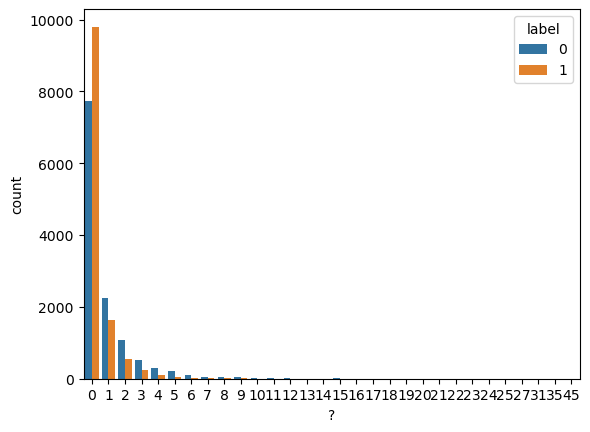

In [8]:
import seaborn as sns

data = train_df.copy()
data["?"] = data["review"].str.count("\\?")
sns.countplot(data, x="?", hue="label")

Ah, so if there are no question marks, the review is more likely to be positive. Inversely we can say if the review contains a question, it's likely the review is negative.

Instead of analyzing the data ourselves to find which characters are associated with positive or negative reviews, our model did the analysis for us. We let the model learn about the data, then in turn we leveraged what the model learned to gain an insight into the data. As we make better models and richer representations of the input text, the amount of information the model can tell us about the data will increase as well.

## Pipelines

Before we dig in to a bag of characters implementation, this is a good time to learn about pipelines. Machine learning is an end to end process, and pipelines are a way to encapsulate that process in scikit-learn.[Pipelines are common patterns outside of scikit-learn as well. It's really a way to string processes together in a nice, repeatable way.]{.aside} Whenever we perform preprocessing, the preprocessor must be fit to the training data, then the training data is transformed, and finally passed to the model for training. Then during prediction, the data must be transformed the same way before being passed to the model. Preprocessing can become very complicated with multiple preprocessors working on the data before it is handed off to the model for training. If we forget one preprocessing step during prediction, the model could throw an error, or worse it can silently fail and suffer poor performance. Pipelines prevent this from occuring by ensuring that the steps taken during training are repeated during prediction.

Let's make a pipeline.

In [9]:
from sklearn.pipeline import Pipeline

# Create a new preprocessor and model.
boc = CountVectorizer(analyzer="char", lowercase=False)
oner = OneR()

# Outline the steps for the pipeline.
# This is an array of tuples where each tuple is a step.
# Each tuple contains the name of the step as the first
# element (we can name these steps whatever we like) and
# the estimator/transformer as the second element.
steps = [("boc", boc), ("OneR", oner)]

# Set up the pipeline.
pipeline = Pipeline(steps)

# Train and score the pipeline.
pipeline.fit(X, y)
pipeline.score(X_test, y_test)

0.5812817904374364

Nice, that gave the same result and we didn't have to remember to apply the preprocessing transform to the test data. One thing to note about pipelines is all but the last step need to have a `transform` method. The last step needs a `predict` method. Basically pipelines string together transformers, then pass the output of that process to the last step which is a model.

## Rolling our own feature extractor {#sec-rolling-our-own-boc}

We've already handled the OneR model, now let's make a bag of characters transformer.

In [10]:
from sklearn.base import TransformerMixin


class BagOfChars(TransformerMixin, BaseEstimator):
    """Bag of characters feature extractor."""

    def fit(self, X, y=None):
        """Fit on all characters in the array `X`.

        Note: `X` should be a 1d array.
        """
        # We want a 1d text array so we'll check its shape here.
        # While iterating over the array values we'll check
        # they are text while trying to extract characters.
        assert len(X.shape) == 1

        vocabulary_ = {}
        # Iterate over each string in the array.
        for x in X:
            # Check it's a string!
            assert isinstance(x, str)

            # Get the unique characters in the string.
            chars = np.unique(list(x))

            # Add each character to the vocabulary if it isn't
            # there already.
            for char in chars:
                if char not in vocabulary_:
                    vocabulary_[char] = len(vocabulary_)

        self.vocabulary_ = vocabulary_

        return self

    def transform(self, X):
        """Transform `X` to a count matrix.

        Note: `X` should be a 1d array.
        """
        # Run our own checks.
        assert len(X.shape) == 1

        # Create a matrix to hold the counts.
        rv = np.zeros((X.shape[0], len(self.vocabulary_)), dtype=int)
        # Iterate over each string in the array.
        for i, x in enumerate(X):
            # Check it's a string!
            assert isinstance(x, str)

            # Get the unique characters in the string and their
            # counts.
            chars, counts = np.unique(list(x), return_counts=True)
            # Add each character count to the count matrix
            # for the specific row.

            for char, count in zip(chars, counts):
                # Make sure the character is part of the vocabulary,
                # otherwise ignore it.
                if char in self.vocabulary_:
                    rv[i, self.vocabulary_[char]] = count

        # Return the count matrix.
        return rv

Let's plug it into a pipeline and see how it goes.

In [11]:
boc = BagOfChars()
oner = OneR()
pipeline = Pipeline([("boc", boc), ("oner", oner)])

# Train it!
pipeline.fit(X, y)
pipeline.score(X_test, y_test)

0.5812817904374364

Easy peasy.